In [1]:
import random
import numpy as np
import scipy
import sympy as sp
import matplotlib
from matplotlib import pyplot as plt
import time

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
from inspect import getfullargspec

# Additional

In [2]:
A = time.time()


def rand(m=2**20, k=5**8):
    global A
    A = (k * A) % m

    return A / m

# Task 1

In [3]:
# f = lambda x, y : (1 / np.pi) * np.exp(-x**2 - y**2)
# f_str = 'exp(- x^2 - y^2) / pi'
# f_str = '1 / (2 * ((pi^2 + x^2 + y^2)^3)**0.5)'
f_str = 'exp(- x^2 - (y)^2) / pi'
f_sp = sp.sympify(f_str)
f = sp.lambdify(sp.symbols('x, y'), f_sp)

## Проверить составляющие двумерной НСВ на независимость

In [4]:
def get_component_pdf(f_sp):
    f_x_sp = sp.integrate(f_sp, (sp.symbols('y'), -sp.oo, sp.oo))
    f_y_sp = sp.integrate(f_sp, (sp.symbols('x'), -sp.oo, sp.oo))

    return f_x_sp, f_y_sp

In [5]:
f_x_sp, f_y_sp = get_component_pdf(f_sp)

print('f(x):')
display(f_x_sp)

print('f(y):')
display(f_y_sp)

f(x):


exp(-x**2)/sqrt(pi)

f(y):


exp(-y**2)/sqrt(pi)

In [6]:
def check_component_independence(f_sp, f_x_sp, f_y_sp):
    mul = sp.simplify(sp.Mul(f_x_sp, f_y_sp))

    return mul.equals(f_sp), mul

In [7]:
is_independent, mul = check_component_independence(f_sp, f_x_sp, f_y_sp)

print('f(x) * f(y): ')
display(mul)

print('f(x, y): ')
display(f_sp)

print('Is f(x, y) == f(x) * f(y): ', is_independent)

f(x) * f(y): 


exp(-x**2 - y**2)/pi

f(x, y): 


exp(-x**2 - y**2)/pi

Is f(x, y) == f(x) * f(y):  True


## Найти условные плотности распределения

In [8]:
def get_conditional_density(f_sp, f_x_sp, f_y_sp):
    f_x_when_y_sp = sp.simplify(f_sp / f_y_sp)
    f_y_when_x_sp = sp.simplify(f_sp / f_x_sp)

    return f_x_when_y_sp, f_y_when_x_sp

In [9]:
f_x_when_y_sp, f_y_when_x_sp = get_conditional_density(f_sp, f_x_sp, f_y_sp)

t1 = ' == f(x)' if f_x_when_y_sp.equals(f_x_sp) else ''
t2 = ' == f(y)' if f_y_when_x_sp.equals(f_y_sp) else ''

print(f'f(x|y){t1}:')
display(f_x_when_y_sp)

print(f'f(y|x){t2}:')
display(f_y_when_x_sp)

f(x|y) == f(x):


exp(-x**2)/sqrt(pi)

f(y|x) == f(y):


exp(-y**2)/sqrt(pi)

## Моделирование

In [10]:
def get_component_inverse_cdf(f_x_sp, f_y_when_x_sp):
    F_x_sp = sp.integrate(f_x_sp, (sp.symbols('x'), -sp.oo, sp.symbols('x')))
    F_y_when_x_sp = sp.integrate(f_y_when_x_sp, (sp.symbols('y'), -sp.oo, sp.symbols('y')))

    F_x_inv_sp = sp.solve(F_x_sp - sp.symbols('z'), sp.symbols('x'))[0]
    F_y_when_x_inv_sp = sp.solve(F_y_when_x_sp - sp.symbols('z'), sp.symbols('y'))[0]
    
    symbols = 'z' if len(F_y_when_x_inv_sp.free_symbols) == 1 else 'z, x'

    F_x_inv = sp.lambdify(sp.Symbol('z'), F_x_inv_sp)
    F_y_when_x_inv = sp.lambdify(sp.symbols(symbols), F_y_when_x_inv_sp)

    return F_x_inv, F_y_when_x_inv

In [11]:
def get_inverse_function(f):
    def f_inv(y, *args):
        res = scipy.optimize.minimize(lambda x, y, *args: abs(f(x, *args) - y), np.array(-5), args=(y, *args), method='Nelder-Mead', tol=1e-4)

        if res['message'] != 'Optimization terminated successfully.':
            raise RuntimeError(f'Optimizer stopped with an message: {res["message"]}')

        return res['x'][0]

    return f_inv

In [12]:
def get_component_inverse_cdf_from_pdf(s):
    f_sp = sp.sympify(s)
    f_x_sp, f_y_sp = get_component_pdf(f_sp)
    
    if not (len(f_x_sp.free_symbols) and len(f_y_sp.free_symbols)):
        raise ValueError(f'PDF has no bound: f_x = {f_x_sp}, f_y = {f_y_sp}')
        
    f_x_when_y_sp, f_y_when_x_sp = get_conditional_density(f_sp, f_x_sp, f_y_sp)
    
    F_x_inv, F_y_when_x_inv = None, None
    
    try:
        F_x_inv, F_y_when_x_inv = get_component_inverse_cdf(f_x_sp, f_y_when_x_sp)
    except Exception:
        F_x_sp = sp.integrate(f_x_sp, (sp.symbols('x'), -sp.oo, sp.symbols('x')))
        F_y_when_x_sp = sp.integrate(f_y_when_x_sp, (sp.symbols('y'), -sp.oo, sp.symbols('y')))

        F_x = sp.lambdify(sp.Symbol('x'), F_x_sp)

        symbols = 'y' if len(F_y_when_x_sp.free_symbols) == 1 else 'y, x'
        F_y_when_x = sp.lambdify(sp.symbols(symbols), F_y_when_x_sp)

        F_x_inv, F_y_when_x_inv = get_inverse_function(F_x), get_inverse_function(F_y_when_x)

    return F_x_inv, F_y_when_x_inv

In [13]:
def generate(F_x_inv, F_y_when_x_inv, N=10**3):
    points = []
    
    for i in range(N):
        x = F_x_inv(rand())
        args = (rand(), x) if F_y_when_x_inv.__code__.co_argcount == 2 else (rand(),)

        points.append(
            (x, 
            F_y_when_x_inv(*args))
            )

    return points

## Построить гистограммы составляющих двумерной НСВ и графики их плотностей распределения в одной системе координат

In [14]:
def plot_2d(x_points, f_x, fig, ax, bins=50):
    ls = np.linspace(np.min(x_points), np.max(x_points), 100)
    
    ax.cla()
    ax.hist(x_points, bins=bins, density=True, histtype='step', label='Empirical');
    
    ax.plot(ls, [f_x(i) for i in ls], color='red')
    fig.canvas.draw_idle()
    plt.show()

    return fig, ax

## Построить гистограмму распределения двумерной НСВ и график плотности распределения в одной системе координат (3D-график)

In [15]:
def plot_bar3d(ax, x_points, y_points, bins, alpha=0.1):
    x, y = np.array(x_points), np.array(y_points)
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)

    x, y = np.meshgrid(x_edges[:-1], y_edges[:-1], indexing="ij")

    dx = dy = x_edges[1] - x_edges[0]

    dz = hist.ravel()
    cmap = plt.get_cmap('turbo')
    ax.bar3d(x.ravel(), y.ravel(), 0, dx, dy, dz, color=[cmap((z - dz.min()) / dz.max()) for z in dz], alpha=alpha)

In [16]:
def plot_surface(ax, f, x_points, y_points):
    ls1 = np.linspace(np.min(x_points), np.max(x_points), 100)
    ls2 = np.linspace(np.min(y_points), np.max(y_points), 100)
    ls1, ls2 = np.meshgrid(ls1, ls2)

    ax.plot_surface(ls1, ls2, np.array([f(*point) for point in zip(ls1, ls2)]), cmap=matplotlib.cm.coolwarm, alpha=1)

In [17]:
def plot_3d(ax, f, x_points, y_points, bins=20, v=30, h=70):    
    # ax = plt.axes(projection='3d')
    ax.cla()
    ax.view_init(v, h)

    plot_bar3d(ax, x_points, y_points, bins=bins, alpha=0.15)
    plot_surface(ax, f, x_points, y_points)

    plt.show()

## Вычислить теоретические, точечные и интервальные значения характеристик двумерной НСВ (математическое ожидание, дисперсия, корреляция);

In [18]:
def get_theoretical_moments(f, eps=3):
    M_x = scipy.integrate.dblquad(lambda x, y: x * f(x, y), -np.inf, np.inf, -np.inf, np.inf)[0]
    M_y = scipy.integrate.dblquad(lambda x, y: y * f(x, y), -np.inf, np.inf, -np.inf, np.inf)[0]

    D_x = scipy.integrate.dblquad(lambda x, y: (x - M_x)**2 * f(x, y), -np.inf, np.inf, -np.inf, np.inf)[0]
    D_y = scipy.integrate.dblquad(lambda x, y: (y - M_y)**2 * f(x, y), -np.inf, np.inf, -np.inf, np.inf)[0]

    r_xy = scipy.integrate.dblquad(lambda x, y: (x - M_x) * (y - M_y) * f(x, y), -np.inf, np.inf, -np.inf, np.inf)[0] / np.sqrt(D_x * D_y)

    return {
        'M' : (round(M_x, eps), round(M_y, eps)),
        'D' : (round(D_x, eps), round(D_y, eps)),
        'r' : round(r_xy, eps)
    }

In [19]:
def get_empirical_moments(x_points, y_points, alpha=0.05, eps=3):
    M_x_empirical = sum(x_points) / len(x_points)
    M_y_empirical = sum(y_points) / len(y_points)

    x_points_centered = (np.array(x_points) - M_x_empirical)
    y_points_centered = (np.array(y_points) - M_y_empirical)

    D_x_empirical = (x_points_centered @ x_points_centered) / (len(x_points) - 1)
    D_y_empirical = (y_points_centered @ y_points_centered) / (len(y_points) - 1)

    r_xy_empirical = (x_points_centered @ y_points_centered) / (len(x_points) * np.sqrt(D_x_empirical * D_y_empirical))

    gamma = 1.0 - alpha
    delta_x = np.abs(D_x_empirical * scipy.stats.t.ppf(gamma, len(x_points) - 1) / np.sqrt(len(x_points) - 1))
    delta_y = np.abs(D_x_empirical * scipy.stats.t.ppf(gamma, len(y_points) - 1) / np.sqrt(len(y_points) - 1))

    lx = ((len(x_points) - 1) * D_x_empirical) / scipy.stats.chi2.ppf(1 - alpha / 2, len(x_points) - 1)
    rx = ((len(x_points) - 1) * D_x_empirical) / scipy.stats.chi2.ppf(alpha / 2, len(x_points) - 1)

    ly = ((len(x_points) - 1) * D_y_empirical) / scipy.stats.chi2.ppf(1 - alpha / 2, len(y_points) - 1)
    ry = ((len(x_points) - 1) * D_y_empirical) / scipy.stats.chi2.ppf(alpha / 2, len(y_points) - 1)

    r_scaled = np.arctanh(r_xy_empirical)
    r_scaled_std = 1 / np.sqrt(len(x_points) - 3)
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    rxy_l, rxy_r = np.tanh(r_scaled - z * r_scaled_std), np.tanh(r_scaled + z * r_scaled_std)

    return {
        'M' : (round(M_x_empirical, eps), round(M_y_empirical, eps)),
        'D' : (round(D_x_empirical, eps), round(D_y_empirical, eps)),
        'r' : round(r_xy_empirical, eps),
        'M_x_interval' : (round(M_x_empirical - delta_x, eps), round(M_y_empirical + delta_x, eps)),
        'M_y_interval' : (round(M_x_empirical - delta_y, eps), round(M_y_empirical + delta_y, eps)),
        'D_x_interval' : (round(lx, eps), round(rx, eps)),
        'D_y_interval' : (round(ly, eps), round(ry, eps)),
        'r_interval' : (round(rxy_l, eps), round(rxy_r, eps)),
    }

## Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим

In [20]:
def check_Mx_hypothesis(M, M_empirical, D_empirical, n, alpha, precision=3):
    u = (M_empirical - M) * np.sqrt(n) / np.sqrt(D_empirical)
    edge = scipy.stats.t.ppf(alpha / 2, n - 1)

    return {
        'value': round(u, precision),
        'l': round(-abs(edge), precision),
        'r': round(abs(edge), precision),
        'result': u < abs(edge),
        'f': scipy.stats.t(n - 1),
        'label': 'Student',
        'alpha': alpha
    }

In [21]:
def check_Dx_hypothesis(D, D_empirical, n, alpha, precision=3):
    chi2 = (n - 1) * D_empirical / D

    chi2_l = scipy.stats.chi2.ppf(alpha / 2, n - 1)
    chi2_r = scipy.stats.chi2.ppf(1 - alpha / 2, n - 1)

    return {
        'value': round(chi2, precision),
        'l': round(chi2_l, precision),
        'r': round(chi2_r, precision),
        'result': chi2_l < chi2 < chi2_r,
        'f': scipy.stats.chi2(n - 1),
        'label': 'chi2',
        'alpha': alpha
    }

In [22]:
def check_rxy_hypothesis(r_xy, r_xy_empirical, n, alpha, precision=3):
    z = (np.arctanh(r_xy_empirical) - np.arctanh(r_xy)) * np.sqrt(n - 3)
    edge = scipy.stats.norm.ppf(alpha / 2)

    return {
        'value': round(z, precision),
        'l': round(-abs(edge), precision),
        'r': round(abs(edge), precision),
        'result': z < abs(edge),
        'f': scipy.stats.norm,
        'label': 'Student',
        'alpha': alpha
    }

In [23]:
def plot_hypothesis(d, ax, title='',  eps = 1e-5):
    # ax.cla()
    f = d['f']
    
    l, r = f.ppf(eps), f.ppf(1-eps)

    # if f.pdf(l) > 10**-1:
    #     l = -r
    ls = np.linspace(l, r, 200)

    ax.plot(ls, f.pdf(ls), label=d['label'])

    ax.fill_between(
        x= ls, 
        y1= f.pdf(ls), 
        where= (ls < d['l']) | (ls > d['r']),
        color= "r",
        alpha= 0.3,
        label=f'alpha = {d["alpha"]}')
    
    ax.scatter(d['value'], f.pdf(d['value']), c='r')
    # fig.canvas.draw_idle()
    ax.legend()
    ax.set_title(title)
    # plt.show()

## Interactive

In [24]:
pdf = widgets.Text(
    value='exp(- x^2 - (y)^2) / pi',
    placeholder='Type something',
    description='f(x, y):')

n_slider = widgets.IntSlider(
    value=300,
    min=1,
    max=10**4,
    step=1,
    description='N',
    readout=True,
    readout_format='d',
    continuous_update=False)

bin_slider = widgets.IntSlider(
    value=25,
    min=1,
    max=10**2,
    step=1,
    description='Bins',
    readout=True,
    readout_format='d',
    continuous_update=False)

v_slider_3d = widgets.IntSlider(
    value=45,
    min=0,
    max=90,
    step=1,
    description='v',
    readout=True,
    readout_format='d',
    continuous_update=False,
    orientation='horizontal')

h_slider_3d = widgets.IntSlider(
    value=20,
    min=0,
    max=90,
    step=1,
    description='h',
    readout=True,
    readout_format='d',
    continuous_update=False)

alpha_slider = widgets.FloatSlider(
    value=0.05,
    min=0,
    max=1,
    step=0.01,
    description='α',
    readout=True,
    readout_format='.2f',
    continuous_update=False)

set_button = widgets.Button(description='Set')

out = widgets.Output()
out_initial = widgets.Output()
out_moments = widgets.Output()

In [25]:
def plot_2d_interactive():
    fig, axs, ax3 = None, None, None
    fig2, axs2 = None, None
    points_x, points_y = None, None
    first = True
    first2 = True
    f_sp = sp.sympify(pdf.value)
    f = sp.lambdify(sp.symbols('x, y'), f_sp)
    f_x_sp, f_y_sp = get_component_pdf(f_sp)

    F_x_inv, F_y_when_x_inv = get_component_inverse_cdf_from_pdf(pdf.value)
    points = generate(F_x_inv, F_y_when_x_inv, N = n_slider.value)
    points_x, points_y = [result[0] for result in points], [result[1] for result in points]

    def output_initial_info(change):
        with out_initial:
            clear_output(wait=True)

            f_x_sp, f_y_sp = get_component_pdf(f_sp)
            is_independent, mul = check_component_independence(f_sp, f_x_sp, f_y_sp)
            f_x_when_y_sp, f_y_when_x_sp = get_conditional_density(f_sp, f_x_sp, f_y_sp)

            print('f(x):', f_x_sp)
            print('f(y):', f_y_sp)
            print()
            print(f'Independent: {is_independent} | f(x) * f(y) = {mul}, f(x, y) = {f_sp}')
            print()
            print(f'f(x | y) = {f_x_when_y_sp}')
            print(f'f(y | x) = {f_y_when_x_sp}')
                
    def output_moments(change):
        nonlocal fig2, points_x, points_y, first2, axs2

        # alpha = change['new']
        # if alpha == change['old']:
        #     return

        theoretical = get_theoretical_moments(f, eps=4)
        empirical = get_empirical_moments(points_x, points_y, eps=4)

        alpha = 0.05

        with out_moments:
            clear_output(wait=True)
            
            print(f'Mx, My\t|\tTheoretical: {theoretical["M"]},\tEmpirical: {empirical["M"]},'
                + f'\tInterval: {empirical["M_x_interval"][0]} < Mx < {empirical["M_x_interval"][1]}, {empirical["M_y_interval"][0]} < My < {empirical["M_y_interval"][1]}')
            print(f'Dx, Dy\t|\tTheoretical: {theoretical["D"]},\tEmpirical: {empirical["D"]},'
                + f'\tInterval: {empirical["D_x_interval"][0]} < Dx < {empirical["D_x_interval"][1]}, {empirical["D_y_interval"][0]} < Dy < {empirical["D_y_interval"][1]}')
            print(f'rxy\t|\tTheoretical: {theoretical["r"]},\t\tEmpirical: {empirical["r"]},'
                + f'\t\tInterval: {empirical["r_interval"][0]} < rxy < {empirical["r_interval"][1]}')
            
            # fig2, axs2 = plt.subplots(1, 5, figsize=(6.4 * 3, 4.8)) if fig2 is None else (fig2, axs2)

            M_x_hypothesis = check_Mx_hypothesis(theoretical['M'][0], empirical['M'][0], empirical['D'][0], len(points_x), alpha)
            M_y_hypothesis = check_Mx_hypothesis(theoretical['M'][1], empirical['M'][1], empirical['D'][1], len(points_y), alpha)
            D_x_hypothesis = check_Dx_hypothesis(theoretical['D'][0], empirical['D'][0], len(points_x), alpha)
            D_y_hypothesis = check_Dx_hypothesis(theoretical['D'][1], empirical['D'][1], len(points_y), alpha)
            r_xy_hypothesis = check_rxy_hypothesis(theoretical['r'], empirical['r'], len(points_x), alpha)

            print()
            print(f'CL: {alpha}')
            print(f"M_x\t|\t{M_x_hypothesis['l']} < {M_x_hypothesis['value']} < {M_x_hypothesis['r']} | Ho: {M_x_hypothesis['result']}")
            print(f"M_y\t|\t{M_y_hypothesis['l']} < {M_y_hypothesis['value']} < {M_y_hypothesis['r']} | Ho: {M_y_hypothesis['result']}")
            print(f"D_x\t|\t{D_x_hypothesis['l']} < {D_x_hypothesis['value']} < {D_x_hypothesis['r']} | Ho: {D_x_hypothesis['result']}")
            print(f"D_y\t|\t{D_y_hypothesis['l']} < {D_y_hypothesis['value']} < {D_y_hypothesis['r']} | Ho: {D_y_hypothesis['result']}")
            print(f"r_xy\t|\t{r_xy_hypothesis['l']} < {r_xy_hypothesis['value']} < {r_xy_hypothesis['r']} | Ho: {r_xy_hypothesis['result']}")
            
            # plot_hypothesis(M_x_hypothesis, fig2, axs2[0], title='')
            # plot_hypothesis(M_y_hypothesis, fig2, axs2[1], title='')
            # plot_hypothesis(D_x_hypothesis, fig2, axs2[2], title='')
            # plot_hypothesis(D_y_hypothesis, fig2, axs2[3], title='')
            # plot_hypothesis(r_xy_hypothesis, fig2, axs2[4], title='')
            
            # if not first2:
            #     display(fig2)
            # else:
            #     first2 = False

    def on_n_slider_change(change):
        nonlocal fig, axs, points_x, points_y, first, ax3
        
        N = change['new']
        if N == change['old']:
            return

        F_x_inv, F_y_when_x_inv = get_component_inverse_cdf_from_pdf(pdf.value)

        points = generate(F_x_inv, F_y_when_x_inv, N = N)
        points_x, points_y = [result[0] for result in points], [result[1] for result in points]
        
        with out:
            fig, axs = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8)) if fig is None else (fig, axs)
            if first:
                ax3 = fig.add_subplot(1, 3, 3,  projection='3d')
        
            clear_output(wait=True)
            plot_2d(points_x, sp.lambdify(sp.Symbol('x'), f_x_sp), fig, axs[0], bin_slider.value)
            # symbols = 'y' if len(f_y_when_x_sp.free_symbols) == 1 else 'y, x'
            # plot_2d(points_y, sp.lambdify(sp.symbols(symbols), f_y_when_x_sp), fig, axs[1], bin_slider.value)
            plot_2d(points_y, sp.lambdify(sp.symbols('y'), f_y_sp), fig, axs[1], bin_slider.value)
            plot_3d(ax3, f, points_x, points_y, bins=bin_slider.value, v=v_slider_3d.value, h=h_slider_3d.value)

            
            if not first:
                display(fig)
            else:
                # axs[0].set_title('x')
                # axs[1].set_title('y')
                first = False
            
            output_moments({'new': alpha_slider.value, 'old': -1})

   
    def on_bin_slider_change(change):
        nonlocal fig, axs, points_x, points_y, first, ax3


        bins = change['new']
        if bins == change['old']:
            return
        
        with out:
            fig, axs = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8)) if fig is None else (fig, axs)
            if first:
                ax3 = fig.add_subplot(1, 3, 3, projection='3d')

            clear_output(wait=True)
            plot_2d(points_x, sp.lambdify(sp.Symbol('x'), f_x_sp), fig, axs[0], bins)
            plot_2d(points_y, sp.lambdify(sp.Symbol('y'), f_y_sp), fig, axs[1], bins)
            plot_3d(ax3, f,  points_x, points_y, bins=bins, v=v_slider_3d.value, h=h_slider_3d.value)
            
            if not first:
                display(fig)
            else:
                # axs[0].set_title('x')
                # axs[1].set_title('y')
                first = False
            
            output_moments({'new': alpha_slider.value, 'old': -1})
    
    def set_button_clicked(_):
        try:
            nonlocal f_sp, f, f_x_sp, f_y_sp
            
            f_sp = sp.sympify(pdf.value)
            f = sp.lambdify(sp.symbols('x, y'), f_sp)
            f_x_sp, f_y_sp = get_component_pdf(f_sp)

            on_n_slider_change({'new': n_slider.value, 'old': -1})
            output_moments({'new': alpha_slider.value, 'old': -1})
        except Exception as e:
            with out:
                clear_output(wait=True)
                print('Invalid input!', e)
                raise
    
    def on_change_3d_view(change):
        with out:
            clear_output(wait=True)
            plot_3d(ax3, f, points_x, points_y, bins=bin_slider.value, v=v_slider_3d.value, h=h_slider_3d.value)
            display(fig)

    n_slider.observe(on_n_slider_change, names='value')
    # n_slider.observe(lambda: output_moments({'new': alpha_slider.value, 'old': -1}))

    bin_slider.observe(on_bin_slider_change, names='value')
    # bin_slider.observe(lambda: output_moments({'new': alpha_slider.value, 'old': -1}))

    set_button.on_click(set_button_clicked)

    h_slider_3d.observe(on_change_3d_view, names='value')
    v_slider_3d.observe(on_change_3d_view, names='value')

    alpha_slider.observe(output_moments, names='value')

    # intial
    on_n_slider_change({'new': n_slider.value, 'old': -1})
    on_bin_slider_change({'new': bin_slider.value, 'old': -1})
    output_initial_info(None)
    # output_moments({'new': alpha_slider.value, 'old': -1})
    # output_moments({'new': alpha_slider.value, 'old': -1})

    display(widgets.VBox(
        [
            widgets.HBox([pdf, set_button]), 
            out_initial,
            widgets.HBox(
                [   
                    widgets.VBox(
                        [
                            n_slider, 
                            bin_slider
                        ]),
                    widgets.VBox(
                        [
                            v_slider_3d, 
                            h_slider_3d
                        ]),
                ]), 
            out,
            # alpha_slider,
            out_moments,
        ]))

In [26]:
plot_2d_interactive()

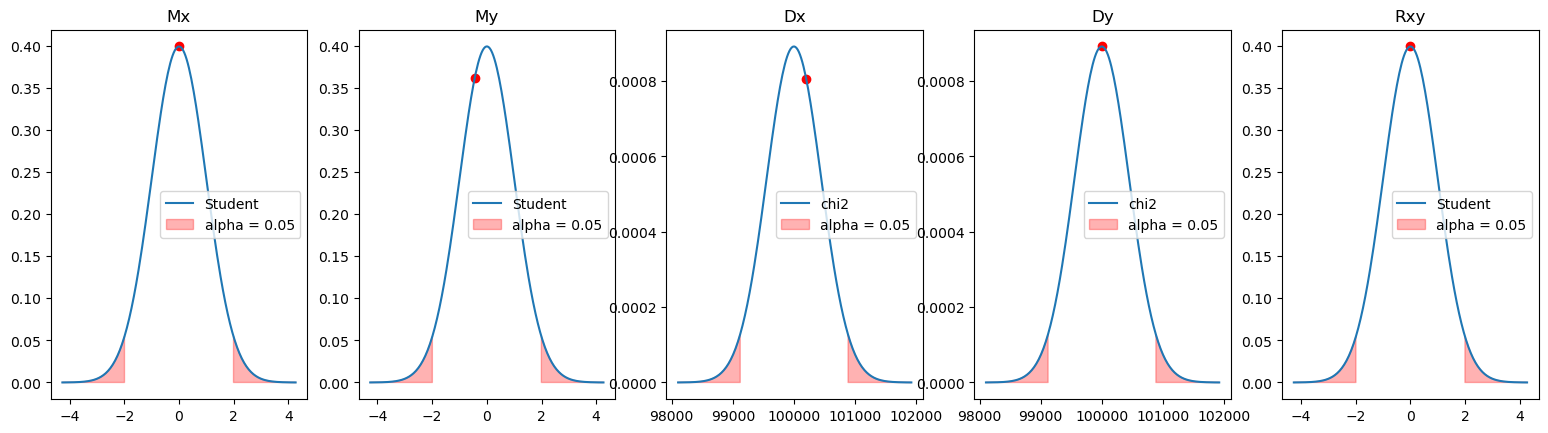

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(6.4 * 3, 4.8))

s = 'exp(- x^2 - y^2) / pi'
f_sp = sp.sympify(s)
f_x_sp, f_y_sp = get_component_pdf(f_sp)
f_x_when_y_sp, f_y_when_x_sp = get_conditional_density(f_sp, f_x_sp, f_y_sp)
F_x_inv, F_y_when_x_inv = get_component_inverse_cdf(f_x_sp, f_y_when_x_sp)

points = generate(F_x_inv, F_y_when_x_inv, N=10**5)
x, y = [point[0] for point in points], [point[1] for point in points]


alpha = 0.05
moments_empirical= get_empirical_moments(x, y, alpha)
moments_theoretical = get_theoretical_moments(sp.lambdify(sp.symbols('x, y'), f_sp))

M_x_hypothesis = check_Mx_hypothesis(moments_theoretical['M'][0], moments_empirical['M'][0], moments_empirical['D'][0], len(x), alpha)
M_y_hypothesis = check_Mx_hypothesis(moments_theoretical['M'][1], moments_empirical['M'][1], moments_empirical['D'][1], len(y), alpha)
D_x_hypothesis = check_Dx_hypothesis(moments_theoretical['D'][0], moments_empirical['D'][0], len(x), alpha)
D_y_hypothesis = check_Dx_hypothesis(moments_theoretical['D'][1], moments_empirical['D'][1], len(y), alpha)
r_xy_hypothesis = check_rxy_hypothesis(moments_theoretical['r'], moments_empirical['r'], len(x), alpha)


plot_hypothesis(M_x_hypothesis, axs[0], title='Mx')
plot_hypothesis(M_y_hypothesis, axs[1], title='My')
plot_hypothesis(D_x_hypothesis, axs[2], title='Dx')
plot_hypothesis(D_y_hypothesis, axs[3], title='Dy')
plot_hypothesis(r_xy_hypothesis, axs[4], title='Rxy')
plt.show()

# Task 2

In [28]:
P = np.array(
    [[0.15, 0.25], 
    [0.05, 0.35],
    [0.15, 0.05]]
    )

x  = np.array([i for i in range(P.shape[0])])
y  = np.array([i for i in range(P.shape[1])])


print(np.sum(P))
assert np.sum(P) == 1

1.0


## Проверить составляющие двумерной НСВ на независимость

In [29]:
independent = True


for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i, j] != np.sum(P[i, :]) * np.sum(P[:, j]):
            independent = False
            break;

In [30]:
print('Is all P(xi, yi) == P(xi) * P(yi): ', independent)

Is all P(xi, yi) == P(xi) * P(yi):  False


## Найти условные плотности распределения

In [31]:
p_xi_when_yj = np.zeros_like(P)

for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        p_xi_when_yj[i, j] = P[i, j] / np.sum(P[:, j])

display(p_xi_when_yj)

array([[0.42857143, 0.38461538],
       [0.14285714, 0.53846154],
       [0.42857143, 0.07692308]])

In [32]:
p_yj_when_xi = np.zeros_like(P)

for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        p_yj_when_xi[i, j] = P[i, j] / np.sum(P[i, :])

display(p_yj_when_xi)

array([[0.375, 0.625],
       [0.125, 0.875],
       [0.75 , 0.25 ]])

## Моделирование

In [33]:
p_x = np.sum(P, axis=1)
p_x

array([0.4, 0.4, 0.2])

In [34]:
def gen4(p: list):
    value = random.random()
    s = 0.
    for i, p_i in enumerate(p):
        s += p_i
        if s > value:
            return i

In [35]:
def generate_d(N):
    result = []

    for i in range(N):
        i = gen4(p_x)
        j = gen4(p_yj_when_xi[i])
        
        result.append((x[i], y[j]))

    return result

In [36]:
result = np.zeros_like(P)

for i in range(10**5):
    result[generate_d(N=1)[0]] += 1

result /= np.sum(result)

result

array([[0.14876, 0.25184],
       [0.04999, 0.34901],
       [0.14971, 0.05069]])

In [37]:
P

array([[0.15, 0.25],
       [0.05, 0.35],
       [0.15, 0.05]])

In [38]:
points = generate_d(N=10**4)


x_points = [result[0] for result in points]
y_points = [result[1] for result in points]

## Построить гистограммы составляющих двумерной ДСВ

In [39]:
def plot_2d_discrete(points):
    values, counts = np.unique(points, return_counts=True)

    plt.bar(
        x=[values[i] for i in range(len(values))],
        height=(counts / counts.sum()),
        width=0.3
        );

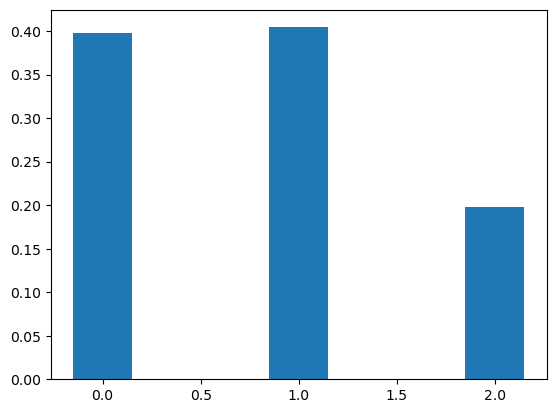

In [40]:
plot_2d_discrete(x_points)

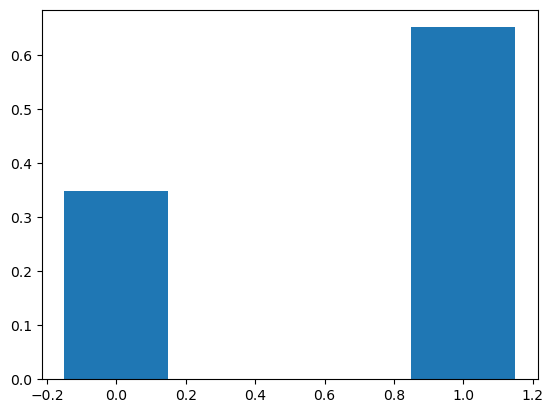

In [41]:
plot_2d_discrete(y_points)

## Построить гистограмму распределения двумерной ДСВ (3D-график)

In [42]:
def plot_bar3d_discrete(points, x, y):
    fig = plt.figure()
    ax = plt.axes(projection = "3d")
    
    data = np.zeros((len(x), len(y)))

    for xi, yi in points:
        data[np.where(x == xi)[0][0], np.where(y == yi)[0][0]] += 1 / len(points)
    
    rows, columns = data.shape
    
    xpos = np.arange(0, rows, 1)
    ypos = np.arange(0, columns, 1)

    xpos, ypos = np.meshgrid(xpos, ypos)
    xpos, ypos = xpos.flatten(), ypos.flatten()
    
    dx = dy = np.ones(rows * columns) * 0.5

    ax.bar3d(xpos, ypos, np.zeros(columns * rows), dx, dy, data.flatten())


    x_labels, y_labels = np.meshgrid(x, y)


    ax.w_xaxis.set_ticks(xpos + dx / 2)
    ax.w_xaxis.set_ticklabels(x_labels.flatten())

    ax.w_yaxis.set_ticks(ypos + dy / 2)
    ax.w_yaxis.set_ticklabels(y_labels.flatten())
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_zlabel('Frequency')
    
    plt.show();

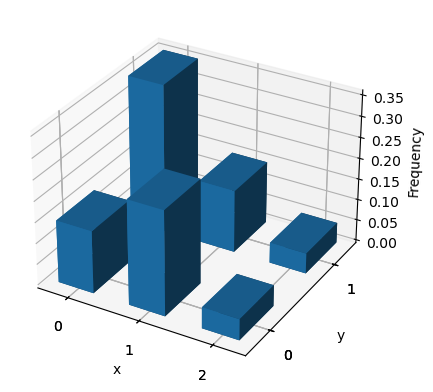

In [43]:
plot_bar3d_discrete(points, x, y)

## Вычислить теоретические, точечные и интервальные значения характеристик двумерной ДСВ (математическое ожидание, дисперсия, корреляция);

In [44]:
def get_theoretical_moments_discrete(P, eps=3):
    p_x, p_y = P.sum(axis=1), P.sum(axis=0)

    M_x = x @ p_x
    M_y = y @ p_y

    D_x = (x - M_x)**2 @ p_x
    D_y = (y - M_y)**2 @ p_y

    r_xy = (x - M_x) @ ((y - M_y) @ P.T) / np.sqrt(D_x * D_y)

    return {
        'M' : (round(M_x, eps), round(M_y, eps)),
        'D' : (round(D_x, eps), round(D_y, eps)),
        'r' : round(r_xy, eps),
    }

In [45]:
precision = 3

theoretical_moments_discrete = get_theoretical_moments_discrete(P)
empirical_moments_discrete = get_empirical_moments(x_points, y_points)

print(f"Theoretical M \t\t{theoretical_moments_discrete['M']}")
print(f"Theoretical D \t\t{theoretical_moments_discrete['D']}")
print(f"Theoretical Rxy \t{theoretical_moments_discrete['r']}")
print()
print(f"Empirical M \t\t{empirical_moments_discrete['M']}\t\
        {empirical_moments_discrete['M_x_interval'][0]} < Mx < {empirical_moments_discrete['M_x_interval'][1]}\
        {empirical_moments_discrete['M_y_interval'][0]} < My < {empirical_moments_discrete['M_y_interval'][1]}")
print(f"Empirical D \t\t{empirical_moments_discrete['D']}\t\
        {empirical_moments_discrete['D_x_interval'][0]} < Dx < {empirical_moments_discrete['D_x_interval'][1]}\
        {empirical_moments_discrete['D_y_interval'][0]} < Dy < {empirical_moments_discrete['D_y_interval'][1]}")
print(f"Empirical Rxy \t\t{empirical_moments_discrete['r']}\t\t   \
    {empirical_moments_discrete['r_interval'][0]} < Rxy < {empirical_moments_discrete['r_interval'][1]}")
print()

Theoretical M 		(0.8, 0.65)
Theoretical D 		(0.56, 0.227)
Theoretical Rxy 	-0.196

Empirical M 		(0.8, 0.652)	        0.791 < Mx < 0.661        0.791 < My < 0.661
Empirical D 		(0.556, 0.227)	        0.541 < Dx < 0.571        0.221 < Dy < 0.233
Empirical Rxy 		-0.197		       -0.216 < Rxy < -0.178



## Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.

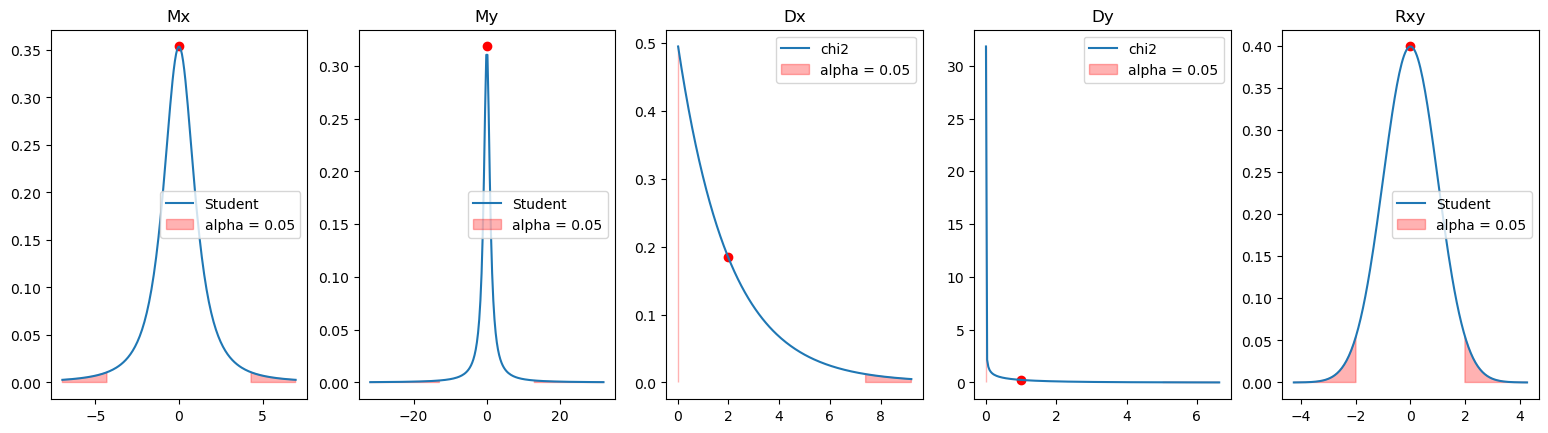

In [46]:
_, axs2 = plt.subplots(1, 5, figsize=(6.4 * 3, 4.8))

alpha = 0.05
M_x_hypothesis_d = check_Mx_hypothesis(theoretical_moments_discrete['M'][0], empirical_moments_discrete['M'][0], empirical_moments_discrete['D'][0], len(x), alpha)
M_y_hypothesis_d = check_Mx_hypothesis(theoretical_moments_discrete['M'][1], empirical_moments_discrete['M'][1], empirical_moments_discrete['D'][1], len(y), alpha)
D_x_hypothesis_d = check_Dx_hypothesis(theoretical_moments_discrete['D'][0], empirical_moments_discrete['D'][0], len(x), alpha)
D_y_hypothesis_d = check_Dx_hypothesis(theoretical_moments_discrete['D'][1], empirical_moments_discrete['D'][1], len(y), alpha)
r_xy_hypothesis_d = check_rxy_hypothesis(theoretical_moments_discrete['r'], empirical_moments_discrete['r'], len(x), alpha)

plot_hypothesis(M_x_hypothesis_d, axs2[0], title='Mx', eps=10**-2)
plot_hypothesis(M_y_hypothesis_d, axs2[1], title='My', eps=10**-2)
plot_hypothesis(D_x_hypothesis_d, axs2[2], title='Dx', eps=10**-2)
plot_hypothesis(D_y_hypothesis_d, axs2[3], title='Dy', eps=10**-2)
plot_hypothesis(r_xy_hypothesis_d, axs2[4], title='Rxy', eps=10**-5)
plt.show()